# single differential $CC1p$ cross-section from begining to end

In [1]:
from Xsec_setup import *
%matplotlib inline
sns.set(font_scale=2);

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


In [2]:
figures_path = '/Users/erezcohen/Desktop/Projects/uBoone/write-ups/Xsec/Figures/1d_differential_Xsec/'

## load mc and data

In [11]:
def sample_in_limits(sam=None):
    return sam[ (Limits['Pmu'][0] < sam['reco_Pmu_mcs']) 
               & (sam['reco_Pmu_mcs']<Limits['Pmu'][1])            
               & (Limits['cos(theta(mu))'][0] < sam['reco_Pmu_cos_theta'])
               & (sam['reco_Pmu_cos_theta']<Limits['cos(theta(mu))'][1])
               & (Limits['Pp'][0] < sam['reco_Pp'])
               & (sam['reco_Pp']<Limits['Pp'][1])
               & (Limits['cos(theta(p))'][0] < sam['reco_Pp_cos_theta'])
               & (sam['reco_Pp_cos_theta']<Limits['cos(theta(p))'][1])
              ]

In [12]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
selected_path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/'
prefix = selected_path + versions['Overlay'] + '_' + versions['overlay date'] + '_'
selected_cosmic_filename = 'selected_cosmic.csv'
selected_overlay=dict()

cuts_order  = ['no cut','Chi2Proton','Nflashes','MatchedFlash','length'
               ,'non-collinearity','vertex activity'
               ,'delta phi','Pt & delta phi']

if os.path.isfile(prefix+selected_cosmic_filename): 
    print 'found '+selected_cosmic_filename+', loading it...'
    for pair_type in pair_types:
        selected_overlay[pair_type]=pd.read_csv(prefix+'selected_'+pair_type+'.csv')
else:
    print 'did not find '+selected_cosmic_filename+', so creating it...'
    OverlaySamples = load_samples(date=versions['overlay date'],filename=versions['Overlay']+'_'+versions['overlay date']+'_vertices')
    reducedOverlay,pureffOverlay,pureffNumbers = apply_cuts_to_overlay(OverlaySamples=OverlaySamples, cuts_order=cuts_order)
    print 'applied cuts to overlay'
    for pair_type in pair_types:
        selected_overlay[pair_type] = sample_in_limits(sam=reducedOverlay['Pt & delta phi'][pair_type])
        outcsvname = prefix+'selected_'+pair_type+'.csv'
        selected_overlay[pair_type].to_csv(outcsvname)
        print 'saved selected',pair_type,'to',outcsvname    
    # overlay scaling
    summary = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/summary/'+versions['overlay date']+'/'+versions['Overlay']+'_'+versions['overlay date']+'_summary.csv')
    Nevents['OnBeam POT'] = 4.908e+19
    Nevents['overlay']      = np.sum(summary.Nevents)
    Nevents['overlay POT']  = np.sum(summary.POT)
    Nevents['f(POT)']       = Nevents['OnBeam POT']/Nevents['overlay POT']
    print "Nevents['f(POT)']:",Nevents['f(POT)']
selected_overlay_concat = pd.concat([selected_overlay['1mu-1p'],selected_overlay['cosmic'],selected_overlay['other pairs']])    
print len(selected_overlay_concat),'events in the overlay'


versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
data_prefix = selected_path + versions['beam on'] + '_' + versions['data date'] + '_'
if os.path.isfile(data_prefix+'selected_beam_on.csv'):
    print 'checked',data_prefix+'selected_on_beam.csv and found the file...'
    selected_beam_on = pd.read_csv(data_prefix+'selected_beam_on.csv')
    selected_beam_off = pd.read_csv(data_prefix+'selected_beam_off.csv')

else:
    print 'checked',prefix+'selected_on_beam.csv and there was no file there...'
    OnBeam = pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['beam on']+'_'+versions['data date']+'_vertices.csv')
    print 'loaded beam-on'
    OffBeam = pd.read_csv(vertices_files_path+'/'+versions['data date']+'/'+versions['beam off']+'_'+versions['data date']+'_vertices.csv')
    print 'loaded beam-off'

    reducedOnBeam,reducedOffBeam,numbers = apply_cuts_to_data(OnBeam=OnBeam,OffBeam=OffBeam,cuts_order=cuts_order)
    print 'applied cuts to data'
    selected_beam_on = sample_in_limits(sam=reducedOnBeam['Pt & delta phi'])
    outcsvname = data_prefix+'selected_beam_on.csv'
    selected_beam_on.to_csv(outcsvname)
    print 'saved selected beam on to',outcsvname

    selected_beam_off = sample_in_limits(sam=reducedOffBeam['Pt & delta phi'])
    outcsvname = data_prefix+'selected_beam_off.csv'
    selected_beam_off.to_csv(outcsvname)
    print 'saved selected beam on to',outcsvname
    
print len(selected_beam_on),'events in the beam-on'
print len(selected_beam_off),'events in the beam-off'


if os.path.isfile(prefix+'selected_genie_CC1p.csv'):
    print 'checked',prefix+'selected_genie_CC1p.csv and found the file...'
    genie_CC1p = pd.read_csv(prefix+'selected_genie_CC1p.csv')
else:
    genie = pd.read_csv('/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/genie/'
                        +versions['overlay date']+'/'
                        +versions['Overlay']+'_'+versions['overlay date']+'_genie.csv')
    print len(genie),'events in genie'
    genie_CC1p = genie[(genie.IsCC_1p_200MeVc==True) 
                       & ((genie.truth_x>3) & (genie.truth_x<256))
                       & ((genie.truth_y>-115) & (genie.truth_y<115))
                       & ((genie.truth_z>5) & (genie.truth_y<1037))
                      ]
    outcsvname = prefix+'selected_genie_CC1p.csv'
    genie_CC1p.to_csv(outcsvname)
    print 'saved genie_CC1p to',outcsvname
    print len(genie_CC1p),'CC1p events in genie'    
selected_CC1p = selected_overlay['CC 1p']
print len(selected_CC1p),'selected CC1p events overlay'

did not find selected_cosmic.csv, so creating it...
285009 ccqe candidate pairs, 180070 in FV
74387 are 1mu-1p, 41.3%
55226 are other pairs, 30.7%
155396 are cosmic, 86.3%
--------------------------------------------------------------
36843 are CC 1p 0pi, 20.5%
--------------------------------------------------------------
40729 are CC 1p, 22.6%
I finished loading overlay samples. We have in total 285009 pairs
applied cuts to overlay
saved selected 1mu-1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_1mu-1p.csv
saved selected other pairs to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_other pairs.csv
saved selected cosmic to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_cosmic.csv
saved selected CC 1p 0pi to /Users/e

In [13]:
def get_eff(Ngen=1,Nsel=1,debug=0):
    '''
    return: eff, eff_err    
    '''
    eff = float(Nsel)/Ngen
    eff_err = eff*np.sqrt(1./Nsel + 1./Ngen)
    if debug: print 'eff = %.4f +/ %.4f'%(eff,eff_err)
    return eff,eff_err

def get_eff_samples(generated=None,selected=None,debug=0):
    '''
    return: eff, eff_err    
    '''
    Ngen = float(len(generated))
    Nsel = float(len(selected))
    return get_eff(Ngen=Ngen,Nsel=Nsel,debug=debug)

In [26]:
def smear_MC(in_sample=None,migration_maps=None,debug=0,name='smeared_mc_tmp'):
    sam = in_sample
    debug=0
    smeared_Pmu_array,smeared_Pmu_theta_array,smeared_Pp_array,smeared_Pp_theta_array = [],[],[],[]
    smeared_Pmu_cos_theta_array,smeared_Pp_cos_theta_array=[],[]
    for i,row in sam.iterrows():

        # smearing p(muon)
        true_bin_j = find_bin(row['truth_Pmu'], Bins['Pmu'])
        smeared_Pmu_array.append(choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_maps['Pmu'][:,true_bin_j]))
#         # smearing theta(muon)
#         true_bin_j = find_bin(180./np.pi*row['truth_Pmu_theta'], Bins['theta(mu)'])
#         smeared_Pmu_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(mu)'][1:]+Bins['theta(mu)'][:-1]) , p=migration_maps['Pmu_theta'][:,true_bin_j]))
        # smearing cos(theta(muon))
        true_bin_j = find_bin(row['truth_Pmu_cos_theta'], Bins['cos(theta(mu))'])
        smeared_Pmu_cos_theta_array.append(choice(a=0.5*(Bins['cos(theta(mu))'][1:]+Bins['cos(theta(mu))'][:-1]) , p=migration_maps['Pmu_cos_theta'][:,true_bin_j]))
        # smearing p(proton)
        true_bin_j = find_bin(row['truth_Pp'], Bins['Pp'])
        smeared_Pp_array.append(choice(a=0.5*(Bins['Pp'][1:]+Bins['Pp'][:-1]) , p=migration_maps['Pp'][:,true_bin_j]))
#         # smearing theta(proton)
#         true_bin_j = find_bin(180./np.pi*row['truth_Pp_theta'], Bins['theta(p)'])
#         smeared_Pp_theta_array.append(np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_maps['Pp_theta'][:,true_bin_j]))
        # smearing cos(theta(p))
        true_bin_j = find_bin(row['truth_Pp_cos_theta'], Bins['cos(theta(p))'])
        smeared_Pp_cos_theta_array.append(choice(a=0.5*(Bins['cos(theta(p))'][1:]+Bins['cos(theta(p))'][:-1]) , p=migration_maps['Pp_cos_theta'][:,true_bin_j]))


        if debug:
            print 'truth_Pmu:',row['truth_Pmu']
            print 'smeared_Pmu:',choice(a=0.5*(Bins['Pmu'][1:]+Bins['Pmu'][:-1]) , p=migration_map[:,find_bin(row['truth_Pmu'], Bins['Pmu'])])        
            print 'truth_Pp_theta:',row['truth_Pp_theta']
            print 'true_bin_j:',true_bin_j
            print 'smeared_Pp_theta:',choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
            print 'smeared_Pp_theta:',np.pi/180.*choice(a=0.5*(Bins['theta(p)'][1:]+Bins['theta(p)'][:-1]) , p=migration_map[:,true_bin_j])
            print_line()

    print 'done looping.'
    sam['smeared_Pmu']=smeared_Pmu_array
#     sam['smeared_Pmu_theta']=smeared_Pmu_theta_array
    sam['smeared_Pmu_cos_theta']=smeared_Pmu_cos_theta_array
    sam['smeared_Pp']=smeared_Pp_array
#     sam['smeared_Pp_theta']=smeared_Pp_theta_array
    sam['smeared_Pp_cos_theta']=smeared_Pp_cos_theta_array
    print 'done smearing',name
    sam.to_csv(prefix + name + '.csv')
    print 'saved ',name,' to\n',(prefix + name + '.csv')
    return sam     

In [15]:
def build_migration_map(sam=None,bins=None,xvar='',yvar='',mul=1,debug=0,do_draw=True):
    xbins = ybins = bins*(1./mul)
    nbins = len(bins)-1
    migration_map = np.zeros((nbins,nbins))
    for ix in range(nbins):
        xmin,xmax = xbins[ix],xbins[ix+1]  
        sum_in_column = 0
        for iy in range(nbins):
            ymin,ymax = ybins[iy],ybins[iy+1]
            sam_bin = sam[(sam[xvar]>xmin)&(sam[xvar]<xmax)&(sam[yvar]>ymin)&(sam[yvar]<ymax)]
            migration_map[ix][iy] = float(len(sam_bin))
            sum_in_column += migration_map[ix][iy]        
        # now normalize the entire column to 1
        for iy in range(nbins):
            migration_map[ix][iy] /= sum_in_column
    migration_map=migration_map.T
    if debug: print 'done computing migration matrix'
    if do_draw:
        fig,ax = plt.subplots(figsize=(9.708,6))
        sns.heatmap(migration_map,annot=True,fmt=".2f",cbar=False,cmap='jet')
        set_axes(ax,'True bin $j$','Reconstructed bin $i$')
        ax.invert_yaxis()
        plt.tight_layout()
    filename = Paths['migration maps'] + "%s_vs_%s_%d_bins.csv"%(xvar,yvar,nbins)
    np.savetxt(filename, migration_map, delimiter=",")
    if debug: print 'saved migration map into',filename
    if debug: print 'done building migration maps'
    return migration_map   

In [16]:
def compute_effiency(bins=Bins['Pmu']
                     ,xvar='smeared_Pmu'
                     ,xlabel=(Vlabels['Pmu']+Units['Pmu'])
                     ,ylabel=r'$\bar{\epsilon}$'
                     ,do_draw=True,debug=0
                     ,mul=1
                    ):
    mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
    h = dict()
    h['generated'],_ = np.histogram(mul*genie_CC1p[xvar],bins=bins)
    h['selected'],_ = np.histogram(mul*selected_CC1p[xvar],bins=bins)

    h['eff'],h['eff err'] = [],[]
    for i in range(len(bins)-1):
        eff,eff_err = get_eff(Ngen=h['generated'][i],Nsel=h['selected'][i])
        h['eff'].append(eff)
        h['eff err'].append(eff_err)
    if debug: print 'done computing efficiency.'
    
    if do_draw:
        fig=plt.figure(figsize=(20,6))
        ax=fig.add_subplot(1,2,1)
        for label,color in zip(['generated','selected'],['forestgreen','royalblue']):
            plt.errorbar(x=mid,xerr=bin_width,y=h[label],yerr=np.sqrt(h[label])
                         ,color=color,capsize=10,fmt='.',markersize=0,label=label)
        set_axes(ax,xlabel,'counts',do_add_grid=True,do_add_legend=True)

        ax=fig.add_subplot(1,2,2)
        plt.errorbar(x=mid,xerr=bin_width,y=h['eff'],yerr=h['eff err']
                         ,color='black',capsize=10,fmt='.',markersize=0)
        set_axes(ax,xlabel,ylabel,do_add_grid=True,ylim=(0,1.05*np.max(h['eff']+h['eff err'])))
    if debug: print 'done drawing.'
    
    # save to csv
    np.savetxt(Paths['efficiency maps'] + "eff_%s_%d_bins.csv"%(xvar,len(bins)-1), h['eff'], delimiter=",")
    np.savetxt(Paths['efficiency maps'] + "eff_err_%s_%d_bins.csv"%(xvar,len(bins)-1), h['eff err'], delimiter=",")
    if debug: print 'saved efficiency into',Paths['efficiency maps'] + "eff_%s_%d_bins.csv"%(xvar,len(bins)-1),'\n and uncertainty'
    return h['eff'],h['eff err']

In [17]:
def subtrsact_bkg_1d(bins=Bins['Pmu'],xlabel='',xvar='reco_Pmu_mcs',mul=1,do_draw=True,debug=0):
    mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
    h,herr = dict(),dict()
    
    # data
    for sam,label in zip([selected_beam_off,selected_beam_on],['beam off','beam on']):
        h[label],_ = np.histogram( mul*sam[xvar] , bins=bins )
        herr[label] = np.sqrt(h[label])
    # scale beam-off to beam-on exposure time
    h['beam off'] = h['beam off']*OffBeam_scaling
    herr['beam off'] = h['beam off']*OffBeam_scaling
    
    # MC
    for sam,label in zip([selected_overlay_concat,selected_overlay['CC 1p']],['overlay','CC 1p']):
        h[label],_ = np.histogram( mul*sam[xvar] , bins=bins )
        h[label] = h[label]*Nevents['f(POT)']
        herr[label] = np.sqrt(h[label])*Nevents['f(POT)']

    h['ovrelay + beam off'] = h['overlay'] + h['beam off']
    herr['overlay + beam off'] = np.sqrt(np.square(herr['overlay']) + np.square(herr['beam off']))
    h['background'] = h['ovrelay + beam off'] - h['CC 1p']
    herr['background'] = np.sqrt(np.square(herr['overlay + beam off']) + np.square(herr['CC 1p']))
    h['beam on bkg subtracted'] = h['beam on'] - h['background']
    herr['beam on bkg subtracted'] = np.sqrt(np.square(herr['beam on']) + np.square(herr['background']))

    if do_draw:
        fig = plt.figure(figsize=(20,6))
        ax=fig.add_subplot(1,2,1)
        ax.bar( mid , h['overlay']+h['beam off'] , width=2*bin_width , color=Colors['beam off'], label='beam-off',alpha=0.7)
        ax.bar( mid , h['overlay'] , width=2*bin_width, color=Colors['overlay'], label='overlay',alpha=0.7)
        ax.bar( mid , h['CC 1p'], width=2*bin_width, color=Colors['CC 1p'], label=r'CC 1p signal')
        ax.errorbar( x=mid , xerr=bin_width, y=h['beam on'], yerr=herr['beam on'] , fmt='o', markersize=10 
                    , color=Colors['beam on'], capsize=1, capthick=3, label='beam-on')
        set_axes(ax,xlabel,do_add_legend=True)
        ylim = ax.get_ylim()

        ax=fig.add_subplot(1,2,2)
        ax.bar( mid , h['CC 1p'], width=2*bin_width, color=Colors['CC 1p'])
        ax.errorbar( x=mid , xerr=bin_width, y=h['beam on bkg subtracted'], yerr=herr['beam on bkg subtracted'] , fmt='o', markersize=10 
                    , color=Colors['beam on'], capsize=1, capthick=3, label='beam-on')
        set_axes(ax,xlabel,do_add_legend=True,ylim=ylim)   
    
    np.savetxt(Paths['background maps'] + "beam_on_bkg_sbtrctd_%s_%d_bins.csv"%(xvar,len(bins)-1), h['beam on bkg subtracted'], delimiter=",")
    np.savetxt(Paths['background maps'] + "beam_on_bkg_sbtrctd_err_%s_%d_bins.csv"%(xvar,len(bins)-1), herr['beam on bkg subtracted'], delimiter=",")
    if debug: print 'saved',"beam_on_bkg_sbtrctd_%s_%d_bins.csv"%(xvar,len(bins)-1)
    
    np.savetxt(Paths['background maps'] + "mc_cc1p_%s_%d_bins.csv"%(xvar,len(bins)-1), h['CC 1p'], delimiter=",")
    np.savetxt(Paths['background maps'] + "mc_cc1p_err_%s_%d_bins.csv"%(xvar,len(bins)-1), herr['CC 1p'], delimiter=",")
    if debug: print 'saved',"mc_cc1p_%s_%d_bins.csv"%(xvar,len(bins)-1) 
    if debug: print 'done background subtraction from data'

In [18]:
def find_bin( x , bins ):    
    for i in range(len(bins)-1):
        if bins[i]<x and x<bins[i+1]:
            return i
    return 0

In [37]:
def Xsec_diff_1d(observable='Pmu',recovar='reco_Pmu_mcs',smearedvar='',ax=None,mc_scale_factor=1,debug=0):
    bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
    xlabel=Vlabel+' ['+units+']' if units is not None else Vlabel

    if smearedvar is '': smearedvar='smeared_'+observable
    mul=180./np.pi if 'theta' in observable else 1
    mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
    
    h,herr = dict(),dict()
    h['N-B'] = np.loadtxt(Paths['background maps'] + "beam_on_bkg_sbtrctd_%s_%d_bins.csv"%(recovar,len(bins)-1), delimiter=",")
    herr['N-B'] = np.loadtxt(Paths['background maps'] + "beam_on_bkg_sbtrctd_err_%s_%d_bins.csv"%(recovar,len(bins)-1), delimiter=",")
    if debug: print 'read ', "beam_on_bkg_sbtrctd_%s_%d_bins.csv"%(recovar,len(bins)-1)

    h['mc'] = np.loadtxt(Paths['background maps'] + "mc_cc1p_%s_%d_bins.csv"%(recovar,len(bins)-1), delimiter=",")
    herr['mc'] = np.loadtxt(Paths['background maps'] + "mc_cc1p_err_%s_%d_bins.csv"%(recovar,len(bins)-1), delimiter=",")
    if debug: print 'read ',"mc_cc1p_%s_%d_bins.csv"%(recovar,len(bins)-1)
    
    h['eff'] = np.loadtxt(Paths['efficiency maps'] + "eff_%s_%d_bins.csv"%(smearedvar,len(bins)-1), delimiter=",")
    herr['eff'] = np.loadtxt(Paths['efficiency maps'] + "eff_err_%s_%d_bins.csv"%(smearedvar,len(bins)-1), delimiter=",")
    if debug: print 'read efficiency',"eff_%s_%d_bins.csv"%(smearedvar,len(bins)-1)
    
    h['Xsec'] = h['N-B']/(h['eff']*Ntargets*flux*bin_width)
    herr['Xsec'] = np.sqrt( np.square(herr['N-B']/(h['eff']*Ntargets*flux*bin_width))
                            +np.square(h['N-B']*herr['eff']/(h['eff']*h['eff']*Ntargets*flux*bin_width))                           
                            +np.square(h['N-B']*Ntargets_err/(h['eff']*Ntargets*Ntargets*flux*bin_width))
                            +np.square(h['N-B']*flux_err/(h['eff']*Ntargets*flux*flux*bin_width)))
    h['Xsec'],herr['Xsec'] = h['Xsec']*1e39,herr['Xsec']*1e39
    
    h['mc'] = h['mc']/(h['eff']*Ntargets*flux*bin_width)
    herr['mc'] = np.sqrt( np.square(herr['mc']/(h['eff']*Ntargets*flux*bin_width))
                            +np.square(h['mc']*herr['eff']/(h['eff']*h['eff']*Ntargets*flux*bin_width))                           
                            +np.square(h['mc']*Ntargets_err/(h['eff']*Ntargets*Ntargets*flux*bin_width))
                            +np.square(h['mc']*flux_err/(h['eff']*Ntargets*flux*flux*bin_width)))
    h['mc'],herr['mc'] = h['mc']*1e39*mc_scale_factor,herr['mc']*1e39*mc_scale_factor


    if ax is None:
        fig,ax = plt.subplots(figsize=(9.708,6))
    ax.bar( x=mid , height=2*herr['mc'], bottom=h['mc']-herr['mc'], width=2*bin_width, color=Colors['CC 1p'], label=r'mc ($\Delta$stat.)')
    ax.errorbar( x=mid , xerr=bin_width, y=h['Xsec'], yerr=herr['Xsec'] , fmt='o', markersize=10 
                , color=Colors['beam on'], capsize=1, capthick=3, label='data')    
    set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +(r'$\left[\frac{cm^{2}}{(%s)}\right]$'%units                                                                               
                         if units is not None                          
                         else r'[cm$^{2}$]'))
             ,do_add_legend=True
             ,title='' if mc_scale_factor == 1 else 'mc scaled by %.3f'%mc_scale_factor)
    if mc_scale_factor == 1:
        np.savetxt(Paths['1d Xsec'] + "Xsec_%s_%d_bins.csv"%(smearedvar,len(bins)-1), h['Xsec'], delimiter=",")
        np.savetxt(Paths['1d Xsec'] + "Xec_err_%s_%d_bins.csv"%(smearedvar,len(bins)-1), herr['Xsec'], delimiter=",")
        if debug: print 'saved',"Xsec_%s_%d_bins.csv"%(smearedvar,len(bins)-1)

        np.savetxt(Paths['1d Xsec'] + "mc_cc1p_Xsec_%s_%d_bins.csv"%(smearedvar,len(bins)-1), h['mc'], delimiter=",")
        np.savetxt(Paths['1d Xsec'] + "mc_cc1p_Xsec_err_%s_%d_bins.csv"%(smearedvar,len(bins)-1), herr['mc'], delimiter=",")
        if debug: print 'saved',"mc_cc1p_Xsec_%s_%d_bins.csv"%(smearedvar,len(bins)-1)
    print 'done computing Xsec.'

In [22]:
def build_migration_maps():
    migration_maps=dict()
    migration_maps['Pmu']=build_migration_map(sam=selected_CC1p,bins=Bins['Pmu'],xvar='truth_Pmu',yvar='reco_Pmu_mcs')
    migration_maps['Pp']=build_migration_map(sam=selected_CC1p,bins=Bins['Pp'],xvar='truth_Pp',yvar='reco_Pp')
#     migration_maps['Pmu_theta']=build_migration_map(sam=selected_CC1p,bins=Bins['theta(mu)'],xvar='truth_Pmu_theta',yvar='reco_Pmu_mcs_theta',mul=180./np.pi)
#     migration_maps['Pp_theta']=build_migration_map(sam=selected_CC1p,bins=Bins['theta(p)'],xvar='truth_Pp_theta',yvar='reco_Pp_theta',mul=180./np.pi)
    migration_maps['Pmu_cos_theta']=build_migration_map(sam=selected_CC1p,bins=Bins['cos(theta(mu))'],xvar='truth_Pmu_cos_theta',yvar='reco_Pmu_cos_theta')
    migration_maps['Pp_cos_theta']=build_migration_map(sam=selected_CC1p,bins=Bins['cos(theta(p))'],xvar='truth_Pp_cos_theta',yvar='reco_Pp_cos_theta')
    return migration_maps

def smear_MC_gen_sel(migration_maps=None):
    smear_MC(in_sample=selected_CC1p,migration_maps=migration_maps,name='selected_CC 1p')
    smear_MC(in_sample=genie_CC1p,migration_maps=migration_maps,name='selected_genie_CC1p')

## 1d cross-section

done looping.
done smearing selected_CC 1p


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

saved  selected_CC 1p  to
/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_CC 1p.csv
done looping.
done smearing selected_genie_CC1p
saved  selected_genie_CC1p  to
/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv
done smearing MC generated and selected


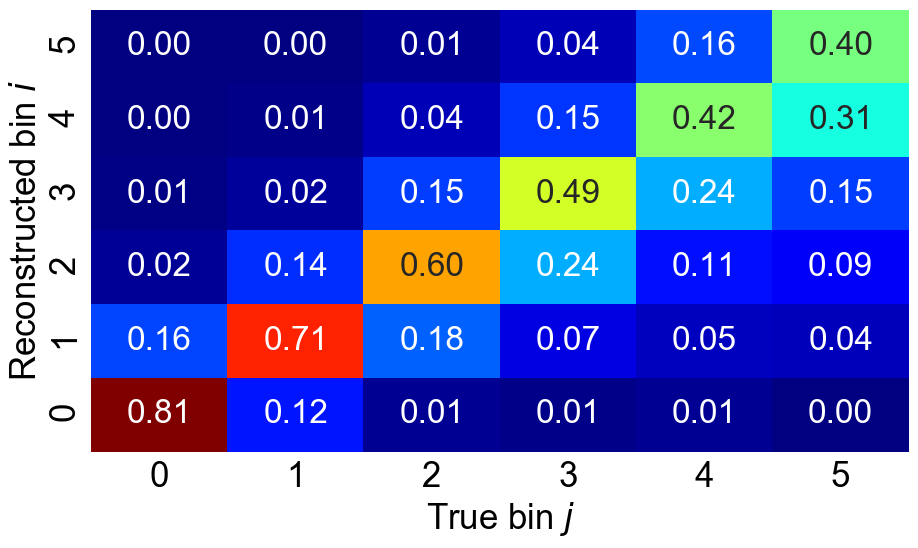

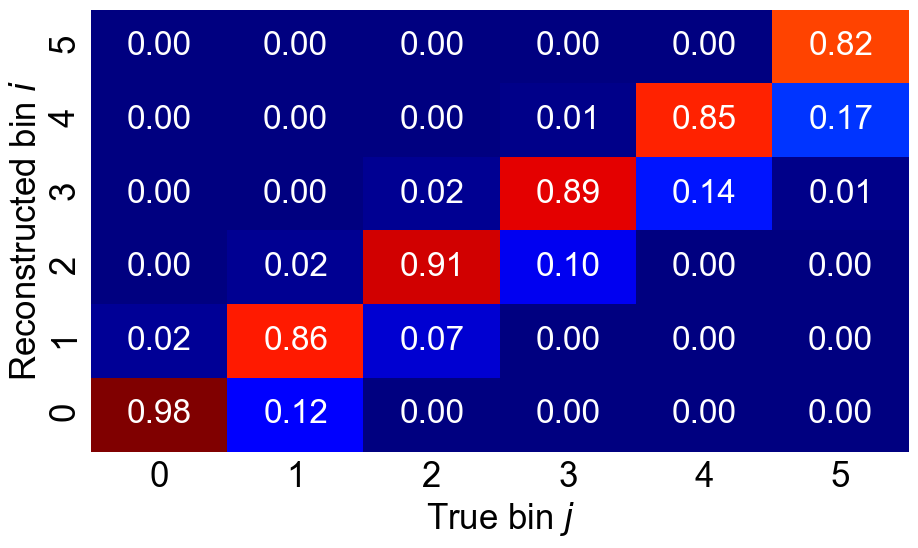

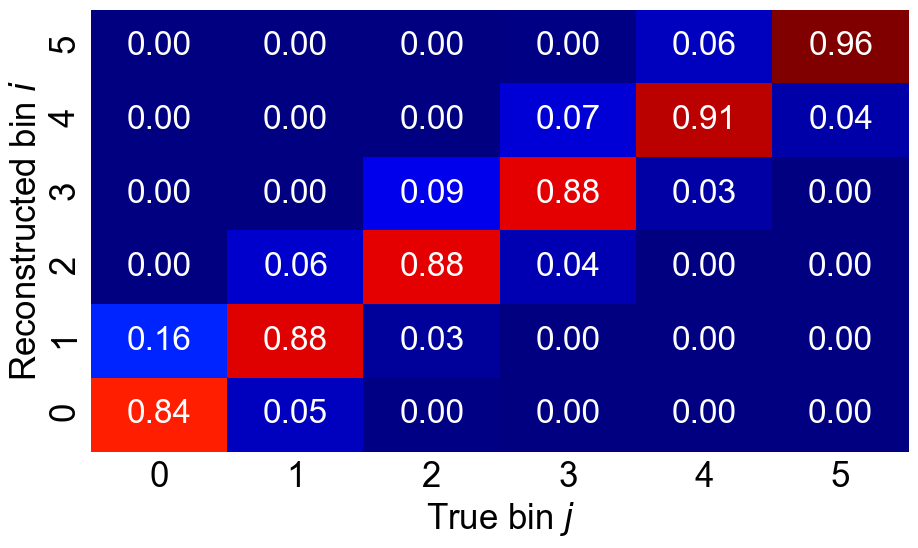

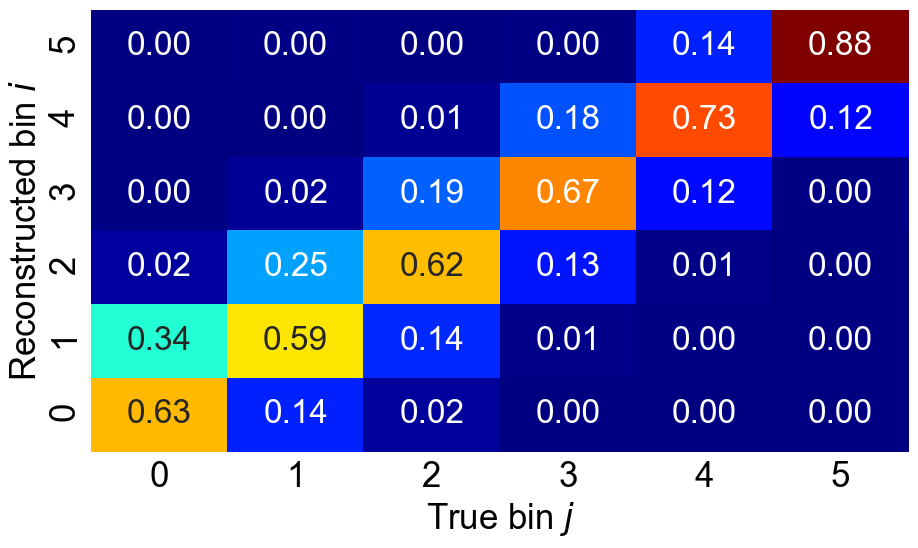

In [27]:
migration_maps = build_migration_maps()
smear_MC_gen_sel(migration_maps=migration_maps)
print 'done smearing MC generated and selected'

In [29]:
print prefix+'selected_genie_CC1p.csv'
genie_CC1p = pd.read_csv(prefix+'selected_genie_CC1p.csv')
selected_CC1p = pd.read_csv(prefix+'selected_CC 1p.csv')

/Users/erezcohen/Desktop/uBoone/CCQEanalysis/csvFiles/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_genie_CC1p.csv


# Xsec.

In [30]:
def full_chain_Xsec_diff_1d(observable='Pmu',truth_var='truth_Pmu',recovar='reco_Pmu_mcs',smearedvar='',mul=1,ax=None
                            ,mc_scale_factor=1):
    bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
    xlabel=Vlabel+' ['+units+']' if units is not None else Vlabel

    # (1) background subtraction    
    subtrsact_bkg_1d(bins=bins,xlabel=xlabel,xvar=recovar,debug=0,do_draw=False)
    
    # (2) efficiency:
    compute_effiency(bins=bins,xvar=smearedvar,xlabel=xlabel,ylabel=r'$\bar{\epsilon}$',do_draw=False,mul=mul,debug=0)    
    
    # (3) cross-section
    Xsec_diff_1d(observable=observable,recovar=recovar,smearedvar=smearedvar,ax=ax,mc_scale_factor=mc_scale_factor,debug=0)

done computing Xsec.
done computing Xsec.
done computing Xsec.
done computing Xsec.


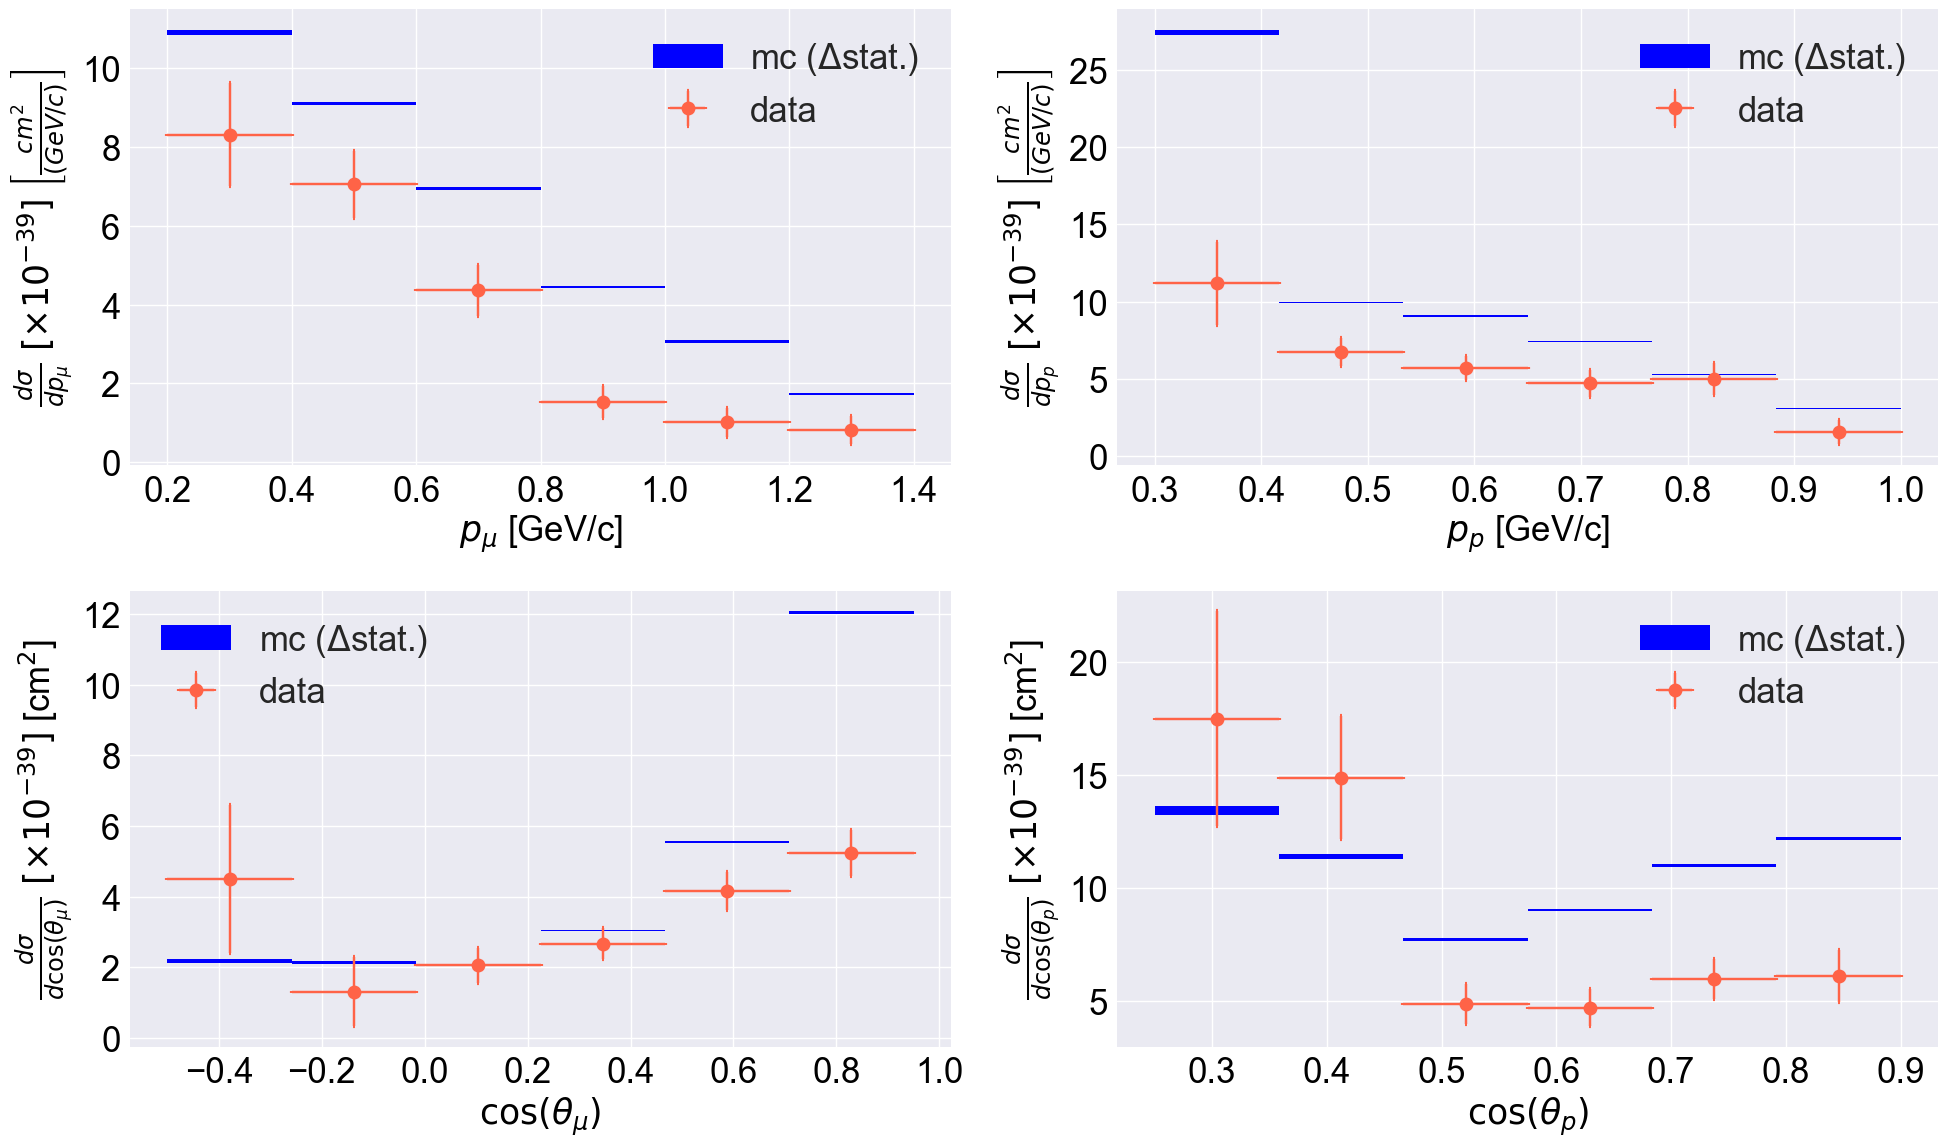

In [38]:
fig=plt.figure(figsize=(20,12))
full_chain_Xsec_diff_1d(observable='Pmu',recovar='reco_Pmu_mcs',smearedvar='smeared_Pmu',ax=fig.add_subplot(2,2,1))
full_chain_Xsec_diff_1d(observable='Pp',recovar='reco_Pp',smearedvar='smeared_Pp',ax=fig.add_subplot(2,2,2))
full_chain_Xsec_diff_1d(observable='cos(theta(mu))',recovar='reco_Pmu_cos_theta',smearedvar='smeared_Pmu_cos_theta',ax=fig.add_subplot(2,2,3))
full_chain_Xsec_diff_1d(observable='cos(theta(p))',recovar='reco_Pp_cos_theta',smearedvar='smeared_Pp_cos_theta',ax=fig.add_subplot(2,2,4))
plt.tight_layout()

done computing Xsec.
done computing Xsec.
done computing Xsec.
done computing Xsec.


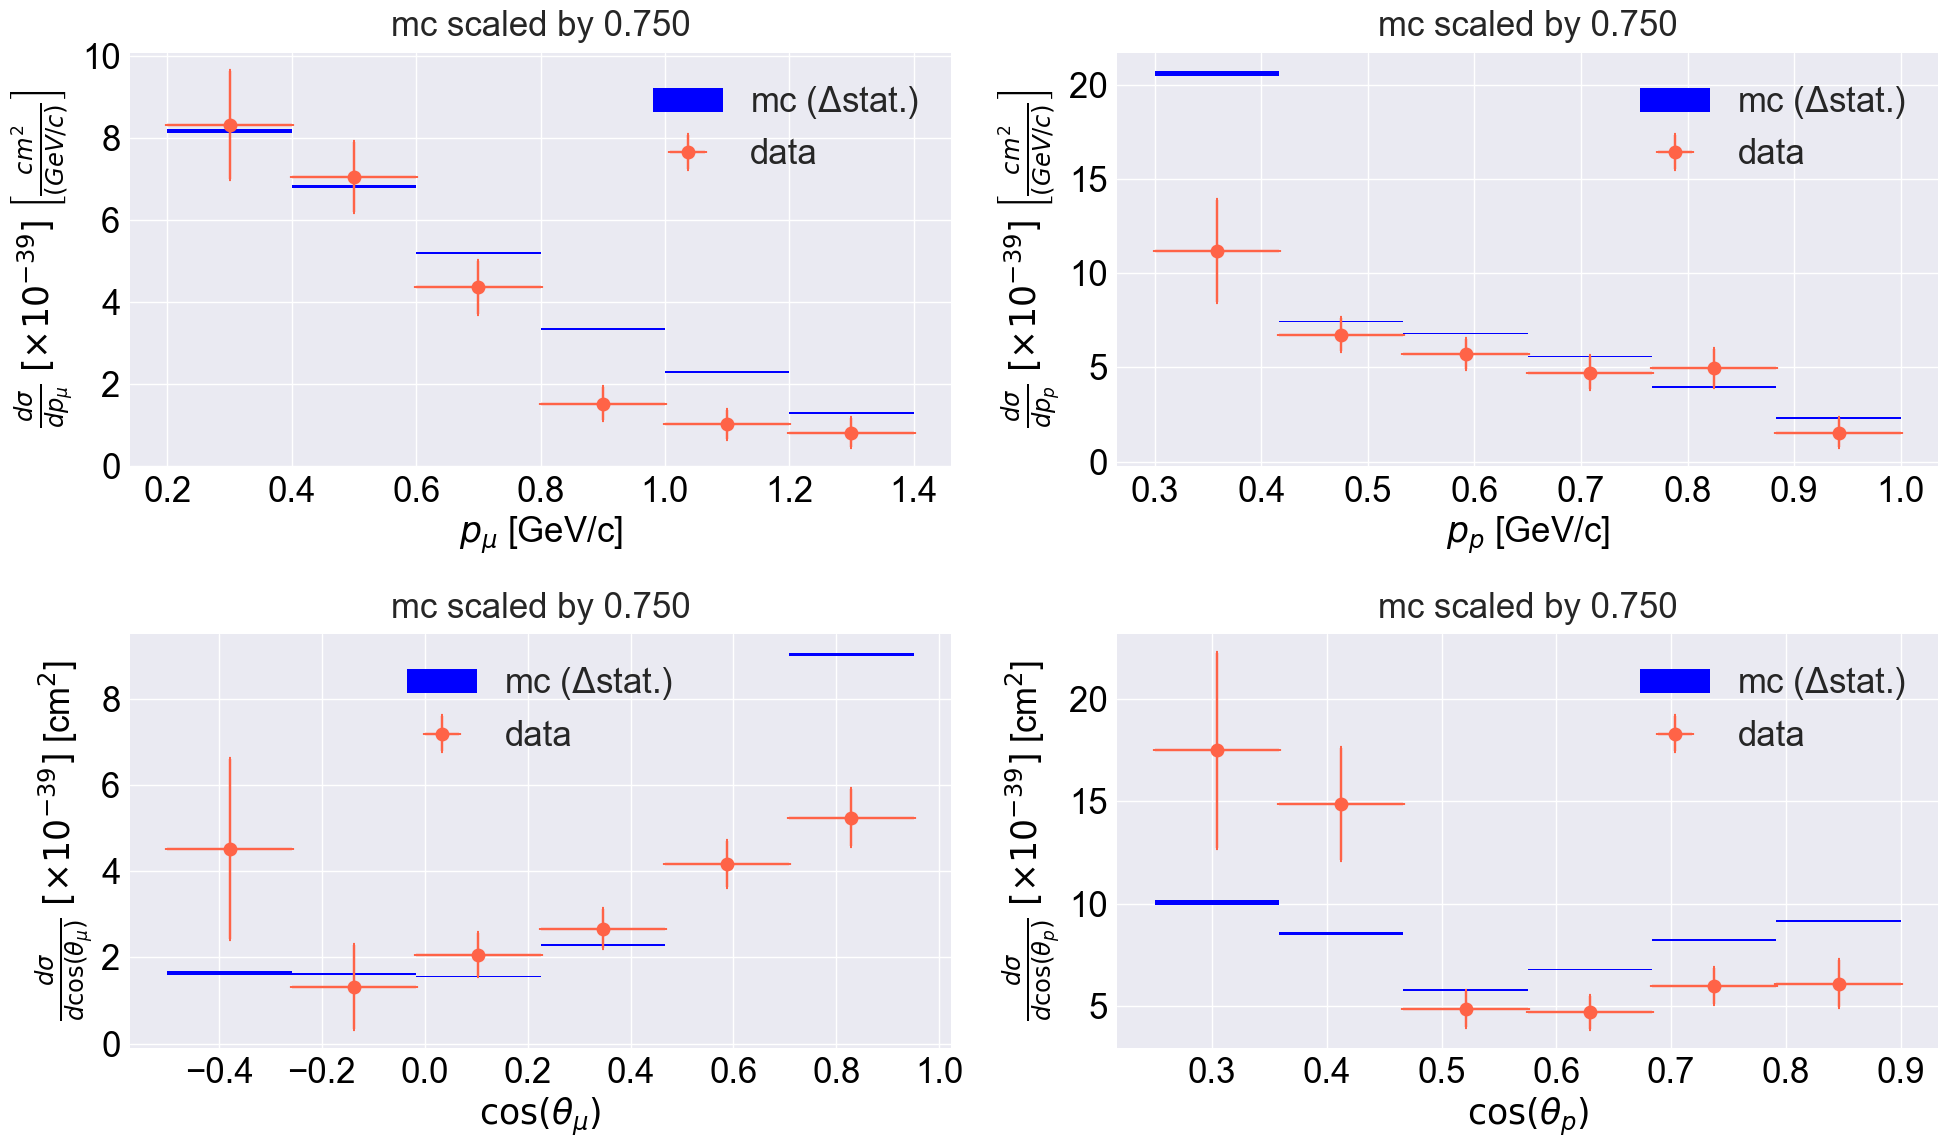

In [42]:
fig=plt.figure(figsize=(20,12))
mc_scale_factor=0.75
full_chain_Xsec_diff_1d(observable='Pmu',recovar='reco_Pmu_mcs',smearedvar='smeared_Pmu',ax=fig.add_subplot(2,2,1),mc_scale_factor=mc_scale_factor)
full_chain_Xsec_diff_1d(observable='Pp',recovar='reco_Pp',smearedvar='smeared_Pp',ax=fig.add_subplot(2,2,2),mc_scale_factor=mc_scale_factor)
full_chain_Xsec_diff_1d(observable='cos(theta(mu))',recovar='reco_Pmu_cos_theta',smearedvar='smeared_Pmu_cos_theta',ax=fig.add_subplot(2,2,3),mc_scale_factor=mc_scale_factor)
full_chain_Xsec_diff_1d(observable='cos(theta(p))',recovar='reco_Pp_cos_theta',smearedvar='smeared_Pp_cos_theta',ax=fig.add_subplot(2,2,4),mc_scale_factor=mc_scale_factor)
plt.tight_layout()